In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import jax
import jax.numpy as jnp
from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
def PlotV(net, config, level_end =500.0, Title = None):
    z1_min, z1_max = -3, 3
    z2_min, z2_max = -2, 2
    z3_min, z3_max = -6, 6

    num_samples_aux_dimension = 128
    def V(z1, z2, z3):
        z = jnp.array([z1, z2, z3])
        return net.potential(z, [config.temperature])
    @jax.vmap
    @jax.jit
    def V_12(z1, z2):
        z3_test_range = jnp.linspace(z3_min, z3_max, num_samples_aux_dimension)
        return jnp.min(jax.vmap(V, (None, None, 0))(z1, z2, z3_test_range))

    @jax.vmap
    @jax.jit
    def V_13(z1, z3):
        z2_test_range = jnp.linspace(z2_min, z2_max, num_samples_aux_dimension)
        return jnp.min(jax.vmap(V, (None, 0, None))(z1, z2_test_range, z3))

    @jax.vmap
    @jax.jit
    def V_23(z2, z3):
        z1_test_range = jnp.linspace(z1_min, z1_max, num_samples_aux_dimension)
        return jnp.min(jax.vmap(V, (0, None, None))(z1_test_range, z2, z3))
    num_grid = 100
    num_levels = 50
    off_set = 1
    level_start = 0.0
    

    custom_levels = jnp.linspace(level_start, level_end, num_levels)
    # custom_levels = None

    # Define the range and number of points in each dimension
    z1_range = jnp.linspace(z1_min - off_set, z1_max + off_set, num_grid)
    z2_range = jnp.linspace(z2_min - off_set, z2_max + off_set, num_grid)
    z3_range = jnp.linspace(z3_min - off_set, z3_max + off_set, num_grid)

    fig, ax = plt.subplots(1, 3, figsize=(15,5))

    # V12
    Z1, Z2 = jnp.meshgrid(z1_range, z2_range)
    
    V12_grid = V_12(Z1.ravel(), Z2.ravel()).reshape(Z1.shape)
    V12_0 = jnp.min(V12_grid) 
    contour1 = ax[0].contour(Z1, Z2, V12_grid - V12_0, levels=custom_levels)
    ax[0].set_title(r'$V_{12}$')
    ax[0].set_xlabel(r'$Z_1$')
    ax[0].set_ylabel(r'$Z_2$')

    # V13
    Z1, Z3 = jnp.meshgrid(z1_range, z3_range)
    V13_grid = V_13(Z1.ravel(), Z3.ravel()).reshape(Z1.shape)
    V13_0 = jnp.min(V13_grid) 
    contour2 = ax[1].contour(Z1, Z3, V13_grid - V13_0, levels=custom_levels)
    ax[1].set_title(r'$V_{13}$')
    ax[1].set_xlabel(r'$Z_1$')
    ax[1].set_ylabel(r'$Z_3$')

    # V23
    Z2, Z3 = jnp.meshgrid(z2_range, z3_range)
    V23_grid = V_23(Z2.ravel(), Z3.ravel()).reshape(Z1.shape)
    V23_0 = jnp.min(V23_grid) 
    contour3 = ax[2].contour(Z2, Z3, V23_grid - V23_0, levels=custom_levels)
    ax[2].set_title(r'$V_{23}$')
    ax[2].set_xlabel(r'$Z_2$')
    ax[2].set_ylabel(r'$Z_3$')
    cbar = fig.colorbar(contour3, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
    if Title is not None:
        fig.suptitle(Title)
    return fig, ax, V12_grid - V12_0, V13_grid - V13_0, V23_grid - V23_0

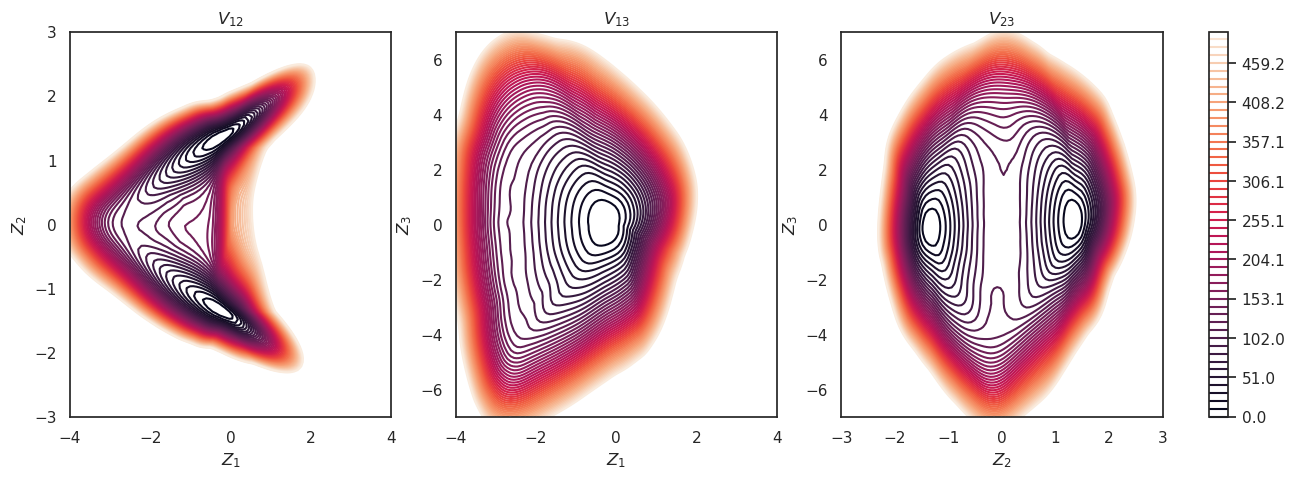

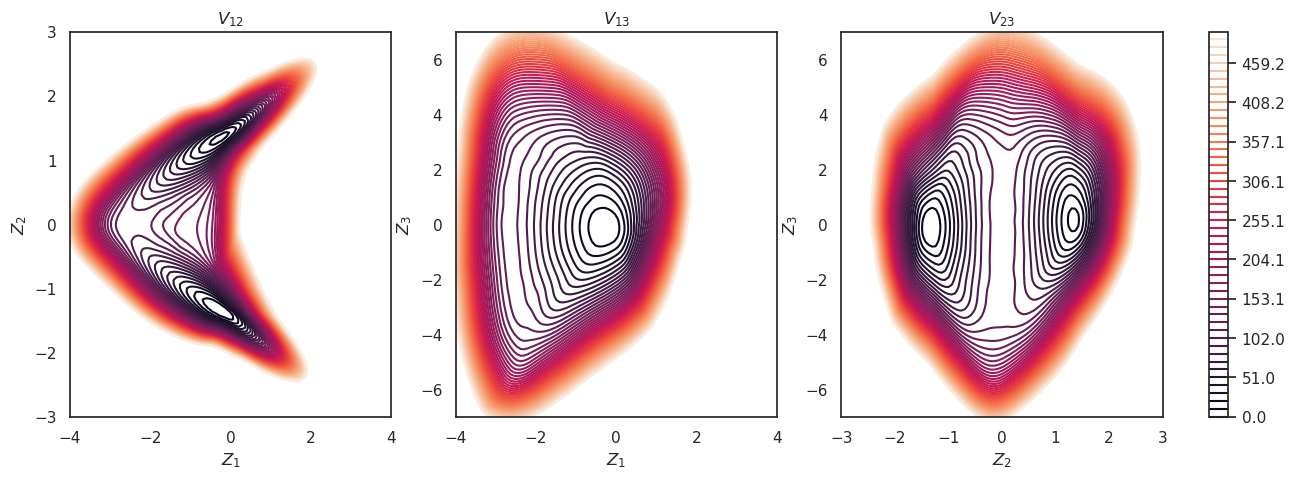

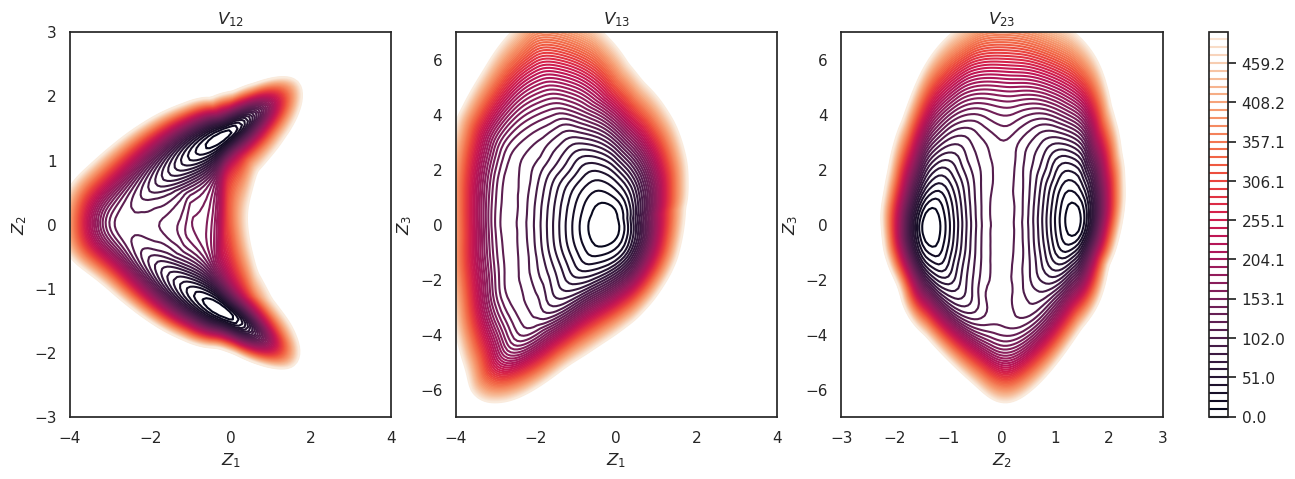

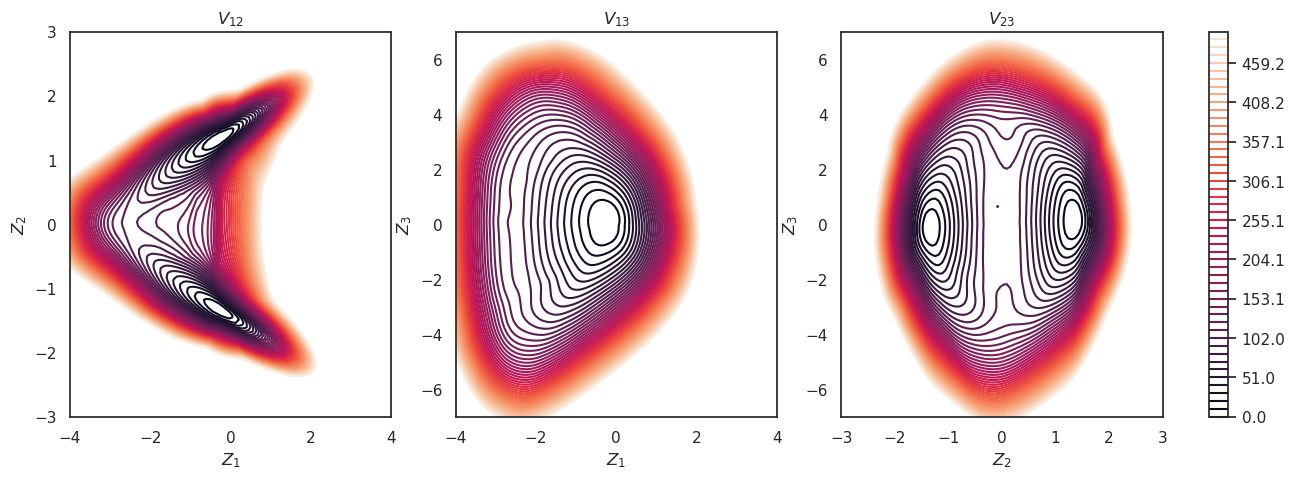

In [ ]:
from omegaconf import OmegaConf
from utils_reduced_polymer import build_OnsagerNetHD2_scale
import equinox as eqx
seed = 0
data_set_key = "F4_63_T1"
V=[]
for seed in [0,1, 12, 123]:
    path =  f"outputs/main{seed}_HD2"
    config = OmegaConf.load(os.path.join(path, ".hydra/config.yaml"))
    model_template = build_OnsagerNetHD2_scale(config) 
    net = eqx.tree_deserialise_leaves(os.path.join(path,data_set_key + '/model.eqx'), model_template) 
    fig, ax,V12, V13,V23 = PlotV(net, config, level_end=500)
    V.append((V12, V13, V23))

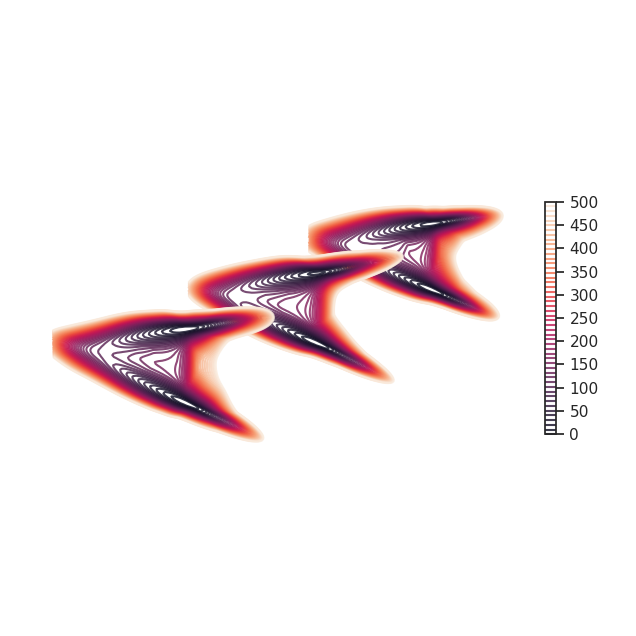

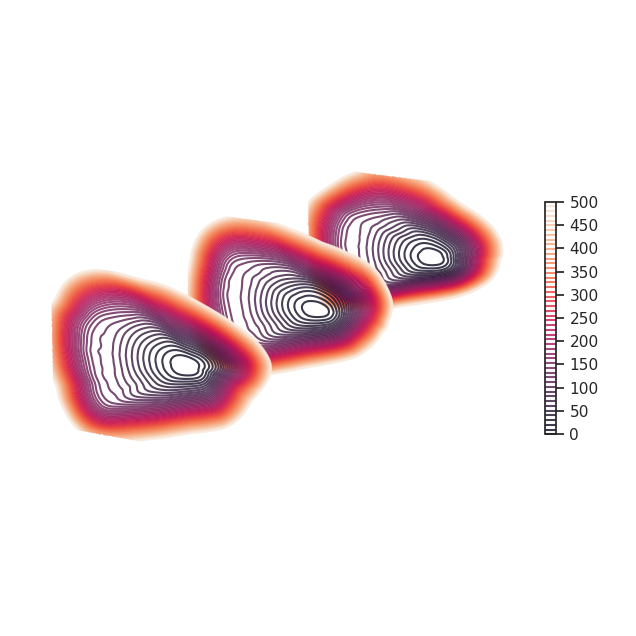

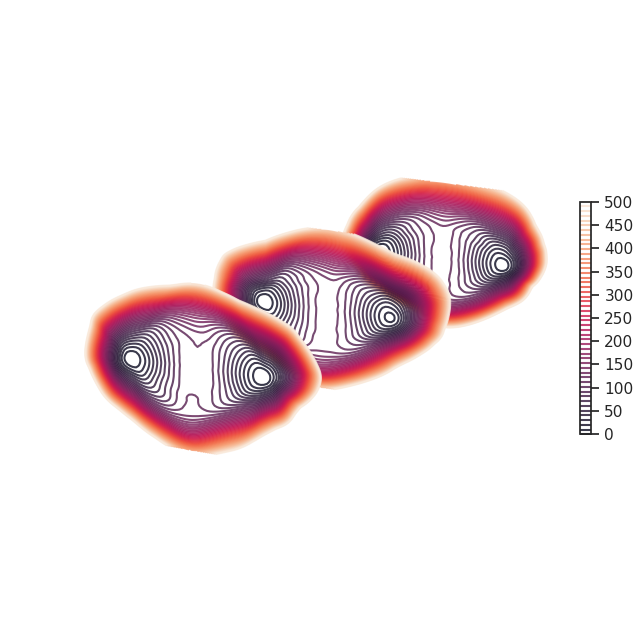

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors

sns.set_theme(style="white")


num_levels = 50 
level_start = 0.0
level_end = 500.0
norm = colors.Normalize(vmin=level_start, vmax=level_end)

custom_levels = jnp.linspace(level_start, level_end, num_levels)

x3 = np.linspace(-3, 3, 100)
z3 = np.linspace(0, 1, 100)
X3, Z3_plane = np.meshgrid(x3, z3) 
 
for i in [0,1,2]: 
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111, projection='3d')
    contour1 = ax.contour(X3, V[0][i], Z3_plane, 20, zdir='y', offset=-3, alpha=0.8, levels=custom_levels)
    contour2 = ax.contour(X3, V[1][i], Z3_plane, 20, zdir='y', offset=0, alpha=0.8, levels=custom_levels)
    contour3 = ax.contour(X3, V[2][i], Z3_plane, 20, zdir='y', offset=3, alpha=0.8, levels=custom_levels)
    pad_list=[-0.07, -0.07, -0.04]
    cbar = fig.colorbar(contour3, ax=ax, orientation='vertical', fraction=0.01, pad=pad_list[i], ticks=np.linspace(level_start,level_end, 11))
    # # 设置坐标范围和标签
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_zlim(0, 1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')



    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.grid(False)

    # 完全移除背景和边框
    ax.set_facecolor('none')      # 透明背景
    fig.set_facecolor('none')     # 透明图形背景
    ax.axis('off')                # 移除坐标轴
    ax.set_frame_on(False)        # 移除边框

    ax.set_box_aspect([2, 3, 1])
    ax.view_init(elev=15, azim=-60) 
    plt.savefig("output.png", bbox_inches="tight", pad_inches=0)
    plt.show()